In [1]:
import os

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import accuracy_score
import aesara.tensor as pt

scaler = StandardScaler()
print(f'PyMC version: {pm.__version__}')

PyMC version: 4.2.2


In [2]:
X_1 = pd.read_csv('../../data/features_4_2/hr/53.csv')
X_2 = pd.read_csv('../../data/features_4_2/eda/53.csv')
# prova con normalizzazione
# X = scaler.fit_transform(X)
X1_train = X_1[:120].to_numpy()
N_train = X1_train.shape[0]
D1 = X1_train.shape[1]
D1

24

In [3]:
X1_train = scaler.fit_transform(X1_train)
X1_train

array([[-1.50201806, -1.50201656, -1.50188077, ..., -1.081495  ,
        -1.01990337, -0.94091361],
       [-1.26119161, -1.26118937, -1.2609871 , ..., -1.00046194,
        -0.97717222, -0.93468915],
       [-0.7225105 , -0.72250901, -0.72237504, ..., -0.82129776,
        -0.80796003, -0.77833435],
       ...,
       [ 1.95018547,  1.95017687,  1.94940182, ...,  1.55333491,
         1.32769629,  1.08968708],
       [-0.58527833, -0.58530354, -0.58757718, ...,  2.74651087,
         2.35115364,  1.93359222],
       [ 0.19098482,  0.19096517,  0.18919248, ...,  3.35511416,
         3.13986105,  2.87285598]])

In [4]:
df_ = pd.read_csv('../../data/LookAtMe_053.csv', sep='\t')
expectancy_label = np.array(list([int(d > 2) for d in df_['rating']]))[:, np.newaxis]
exp_train = expectancy_label[:120]
D2 = exp_train.shape[1]
D2

1

In [5]:
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="aesara"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"aesara", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "aesara":
            return pt.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = pt.zeros((d, k), dtype=float) if mtype == "aesara" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out


def makeW(d, k, dim_names, name):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)
    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z_" + name, 1.0, dims="latent_columns")
    b = pm.HalfNormal("W_b_" + name, 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, pt.ones(k))
    W = pm.Deterministic(name, pt.dot(L, pt.diag(pt.extra_ops.cumsum(z))), dims=dim_names)
    return W

In [6]:
k = 2
# model definition
with pm.Model() as PPCA_identified:
        PPCA_identified.add_coord("latent_columns", np.arange(k), mutable=True)
        PPCA_identified.add_coord("rows", np.arange(N_train), mutable=True)
        PPCA_identified.add_coord("observed_hr", np.arange(D1), mutable=False)
        PPCA_identified.add_coord("observed_label", np.arange(D2), mutable=False)

        hr_data = pm.MutableData("hr_data", X1_train.T, dims=["observed_hr", "rows"])

        W_hr = makeW(D1, k, ("observed_hr", "latent_columns"), 'W_hr')

        W_e = pm.Normal("W_e", dims=["observed_label", "latent_columns"])
        C = pm.Normal("C", dims=["latent_columns", "rows"])


        psi_hr = pm.HalfNormal("psi_hr", 2.0, dims=["observed_hr", "rows"])     #24x120
        X_hr = pm.Normal("X_hr", mu=pt.dot(W_hr, C), sigma=psi_hr, observed=hr_data, dims=["observed_hr", "rows"])


        X_e = pm.Bernoulli("X_e", p=pm.math.sigmoid(pt.dot(W_e, C)), dims=["observed_label", "rows"],
                           observed=exp_train.T)

In [7]:
with PPCA_identified:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    trace = approx.sample(1000)


Finished [100%]: Average Loss = 23,793


In [8]:
gv_ = pm.model_to_graphviz(PPCA_identified)
gv_.view('prova_tmp')

'prova_tmp.pdf'

In [9]:
with PPCA_identified:
    PPCA_identified.set_data('hr_data', X1_train.T, coords={'rows': range(X1_train.shape[0])})
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)

e_pred_train = posterior_predictive.posterior_predictive['X_e']
e_pred_mode_train = np.squeeze(stats.mode(e_pred_train[0], keepdims=False)[0])[:, np.newaxis]


Sampling: [X_e, X_hr]


In [10]:
train_accuracy_exp = accuracy_score(exp_train, e_pred_mode_train)
print(train_accuracy_exp)

0.6083333333333333


In [11]:
latent_space_c = trace.posterior['C']
latent_space_c = np.array(latent_space_c[0].mean(axis=0))

In [12]:
latent_space_c.shape

(2, 120)

In [13]:
latent_space = pd.DataFrame()
latent_space['X'] = np.array(latent_space_c[0])
latent_space['Y'] = np.array(latent_space_c[1])
latent_space['label'] = exp_train
latent_space

,X,Y,label
0,-2.445422,-2.617262,1
1,-1.797687,-2.447903,1
2,-0.963296,-1.459064,1
3,-2.123588,-0.624718,1
4,-2.946615,-3.766640,0
...,...,...,...
115,3.898350,-0.489130,1
116,0.155950,3.038843,0
117,1.848590,4.791890,0
118,-1.210853,4.157639,0


## scatter plot latent space

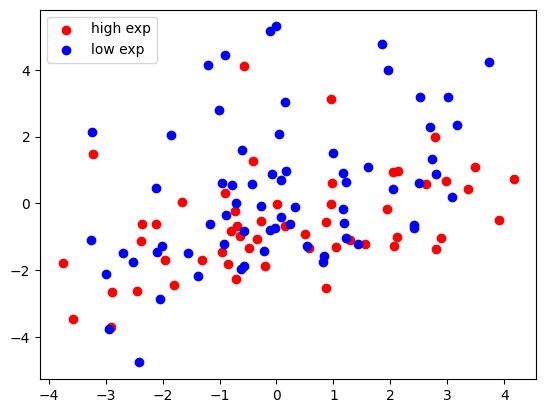

In [14]:
plt.scatter(latent_space[latent_space['label'] == 1].X, latent_space[latent_space['label'] == 1].Y, color = 'r', label='high exp')
plt.scatter(latent_space[latent_space['label'] == 0].X, latent_space[latent_space['label'] == 0].Y, color = 'b', label='low exp')
plt.legend()
plt.show()

In [15]:
def my_post_predict(trace,hr_val):
    whr_ = trace.posterior['W_hr'][0]
    C_val = pt.dot(np.linalg.pinv(whr_), hr_val.T)
    we_ = trace.posterior['W_e'][0]
    val_label_gen = pt.matmul(np.array(we_),C_val.eval())
    label_val = np.where(val_label_gen.eval()<0, 0, 1)
    label_val = stats.mode(label_val[0], keepdims=False)[0]
    return  label_val, C_val

In [16]:
X1_test = X_1[120:].to_numpy()

In [17]:
label, new_latent_space = my_post_predict(trace, X1_test)
new_latent_space = np.array(new_latent_space.eval().mean(axis=0))
new_latent_space

array([[ 801.43375332, 1227.47568147, 1069.52482848,  885.13707548,
        1095.13138531,  858.9933278 , 1647.56529368,  965.70647531,
        1163.95782953, 1158.05772539, 1527.8403857 , 1289.08187868,
        1097.75480169, 1137.96435504, 1060.2571445 ,  933.0728845 ,
        1065.416267  , 1055.14788343, 1305.32410329,  987.44724977,
         969.81672931,  748.55613558, 1415.55654747, 1244.94625906,
        1469.34209139,  964.9968144 ,  882.68557371, 1277.47164055,
        1341.04785132, 1010.24187408, 1103.34318167, 1568.50135357,
        1788.14300447, 1428.35074575, 1249.20593056, 1474.81643084,
         866.35374582, 1355.44860506, 1236.97698994, 1616.80879571],
       [2244.04325316, 2090.16136114, 2462.75299026, 2250.34185453,
        2145.75725443, 2099.55368855, 2139.62990199, 2234.14581463,
        2172.20442813, 2206.99268357, 2129.34270836, 2281.26628147,
        2329.63694218, 2334.8306095 , 2345.03907223, 2226.01602624,
        2471.87212911, 2133.51570294, 2236.7358

In [18]:
e_pred_test = expectancy_label[120:]

latent_space_post = pd.DataFrame()
latent_space_post['X'] = np.array(new_latent_space[0])
latent_space_post['Y'] = np.array(new_latent_space[1])
latent_space_post['label'] = e_pred_test
latent_space_post

,X,Y,label
0,801.433753,2244.043253,0
1,1227.475681,2090.161361,1
2,1069.524828,2462.752990,0
3,885.137075,2250.341855,1
4,1095.131385,2145.757254,0
5,858.993328,2099.553689,1
6,1647.565294,2139.629902,0
7,965.706475,2234.145815,0
8,1163.957830,2172.204428,1
9,1158.057725,2206.992684,1


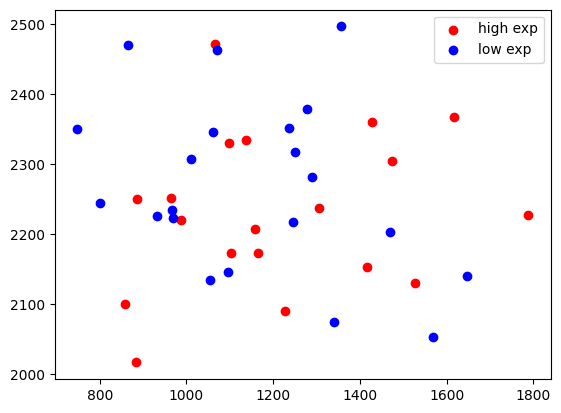

In [19]:
plt.scatter(latent_space_post[latent_space_post['label'] == 1].X, latent_space_post[latent_space_post['label'] == 1].Y, color = 'r', label='high exp')
plt.scatter(latent_space_post[latent_space_post['label'] == 0].X, latent_space_post[latent_space_post['label'] == 0].Y, color = 'b', label='low exp')
plt.legend()
plt.show()

## Logistic regression

In [9]:
import pymc as pm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import stats
from sklearn.metrics import accuracy_score
import aesara.tensor as at
import fear_gen.extract_correct_csv as functions
import os
from sklearn.preprocessing import StandardScaler
import csv

scaler = StandardScaler()
os.chdir('..')
os.chdir('..')
all_subjects = functions.extract_only_valid_subject()
columns = ['subject','type', 'fold', 'train']
with open('output/Regression.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(columns)

types_ = ['hr', 'eda', 'pupil']

for sub in all_subjects:

    for type_ in types_:

        X = pd.read_csv('data/features_4_2/'+type_+'/'+str(sub)+'.csv')
        X = scaler.fit_transform(X)
        X = pd.DataFrame(X)
        X = X[48:]

        df_ = pd.read_csv('data/LookAtMe_0'+functions.read_correct_subject_csv(sub)+'.csv', sep='\t')
        y = np.array(list([int(d > 2) for d in df_['rating']]))[:, np.newaxis]
        y = pd.DataFrame(y)
        y = y[48:]

        sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=123)

        for i, (train_index, test_index) in enumerate(sss.split(X, y)):
            X_train = X.iloc[train_index,:]
            y_train = y.iloc[train_index,:]

            with pm.Model() as GLM:
                intercept = pm.Normal("intercept", 0, 1, shape=y_train.shape)
                slope = pm.Normal("slope", shape=(24,1))
                likelihood = pm.Bernoulli('likelihood', p=pm.math.sigmoid(at.dot(X_train, slope)+intercept), observed=y_train)
                approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
                trace = approx.sample(1000)
                posterior_predictive = pm.sample_posterior_predictive(
                    trace, var_names=["likelihood"], random_seed=123)
            prediction_y = posterior_predictive.posterior_predictive['likelihood']
            e_pred_mode_train = np.squeeze(stats.mode(prediction_y[0], keepdims=False)[0])[:, np.newaxis]

            train_accuracy_exp = accuracy_score(y_train, e_pred_mode_train)
            row = [sub, type_, i, train_accuracy_exp]

            with open('output/Regression.csv', 'a') as f:
                write = csv.writer(f)
                write.writerow(row)

Finished [100%]: Average Loss = 93.189
Sampling: [likelihood]


Finished [100%]: Average Loss = 92.975
Sampling: [likelihood]


Interrupted at 26,050 [26%]: Average Loss = 96.729
Sampling: [likelihood]


Interrupted at 85,967 [85%]: Average Loss = 80.739
Sampling: [likelihood]


Interrupted at 13,970 [13%]: Average Loss = 81.869

KeyboardInterrupt

